# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.8.0
/device:GPU:0


In [2]:
# Data loader
from utils import data_loader

# Data loader
from utils import data_loader

path_train = "data\LITS_Challenge\Training_Batch_2"
path_valid = "data\LITS_Challenge\Training_Batch_1"

loader_train = data_loader.NiiDataLoader(path_train)
loader_valid = data_loader.NiiDataLoader(path_valid)

train_generator = loader_train.data_generator_2d_liver()
valid_generator = loader_valid.data_generator_2d_liver()




"""
#counter_train = loader_train.generator_data_len()
#counter_valid = loader_valid.generator_data_len()
counter_train = 0
counter_valid = 0

for x in train_generator:
    counter_train += 1

for x in valid_generator:
    counter_valid += 1"""

counter_train = 43720
counter_valid = 14918

print(counter_train)
print(counter_valid)

initalised with path data\LITS_Challenge\Training_Batch_2
files: 103,103
initalised with path data\LITS_Challenge\Training_Batch_1
files: 28,28
43720
14918


In [3]:
### learning rate schedule

def scheduler(epoch, lr):
    if epoch < 5:
        lr = 0.001
        return lr
    else:
        return lr * tf.math.exp(-0.02)

In [4]:
#datasets for tf
batch_size = 16
dataset = tf.data.Dataset.from_generator(
     loader_train.data_generator_2d_liver,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])))
dataset = dataset.repeat(101).batch(batch_size)

valid_dataset = tf.data.Dataset.from_generator(
     loader_valid.data_generator_2d_liver,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])))
valid_dataset = valid_dataset.repeat(100).batch(batch_size)#.shuffle(1000,  reshuffle_each_iteration=True)


print(dataset)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>


In [5]:
# Network set-up
from utils import models

model = models.model_call(model_name="2DUNET",px=256,features=16)

In [6]:
# Metrics and training
 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision_all = tf.keras.metrics.Precision(
    thresholds=0.5)
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision_all,precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 256, 256, 1)]           0           []                    
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16)            160         ['input_1[0][0]']     
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16)            2320        ['conv2d[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16)            0           ['conv2d_1[0][0]']    
                                                                                              

In [7]:
# Results
# reading checkpoint if needen
#
#################################

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    ModelCheckpoint(
        "models\\2DUNET_liver\\{epoch:02d}-{val_loss:.4f}-{val_precision_1:.2f}-{val_recall:.2f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
]
epochs = 50
steps_per_epoch = (
    counter_train / batch_size
) 


validations_steps = counter_valid / batch_size

history = model.fit(
    dataset,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
    epochs=epochs,
    validation_steps=validations_steps,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/50
2733/2732 [==============================] - ETA: 0s - loss: 1981.5225 - precision: 0.9760 - precision_1: 0.0488 - recall: 6.0579e-05
Epoch 1: saving model to models\2DUNET_liver\01-0.0766-0.05-0.00.hdf5
2732/2732 [==============================] - 678s 245ms/step - loss: 1981.5225 - precision: 0.9760 - precision_1: 0.0488 - recall: 6.0579e-05 - val_loss: 0.0766 - val_precision: 0.9767 - val_precision_1: 0.3119 - val_recall: 0.1558 - lr: 0.0010
Epoch 2/50
2733/2732 [==============================] - ETA: 0s - loss: 0.0555 - precision: 0.9780 - precision_1: 0.6165 - recall: 0.2184
Epoch 2: saving model to models\2DUNET_liver\02-0.0787-0.62-0.22.hdf5
2732/2732 [==============================] - 682s 249ms/step - loss: 0.0555 - precision: 0.9780 - precision_1: 0.6165 - recall: 0.2184 - val_loss: 0.0787 - val_precision: 0.9744 - val_precision_1: 0.3760 - val_recall: 0.4631 - lr: 0.0010
Epoch 3/50
2733/2732 [==============================] - ETA: 0s - loss: 0.0511 - precision: 0.

: 

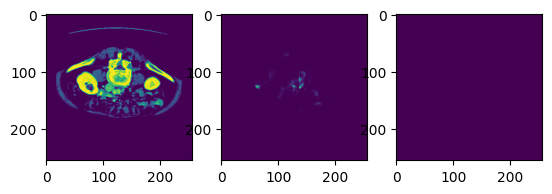

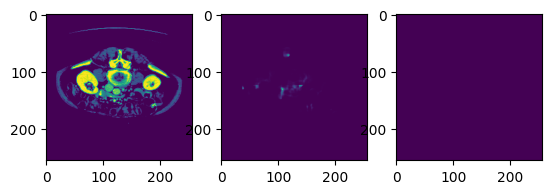

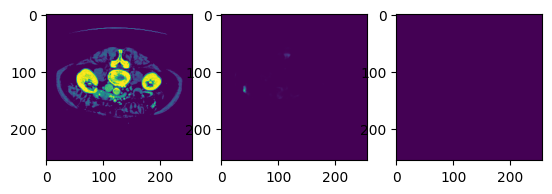

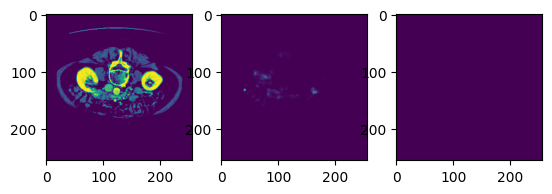

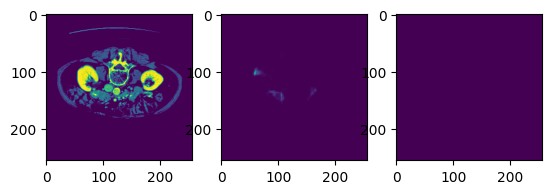

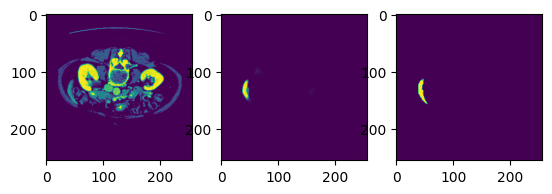

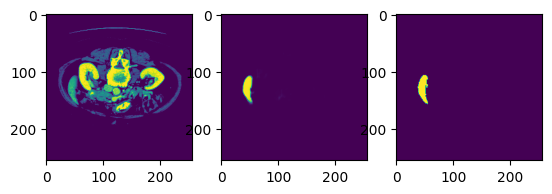

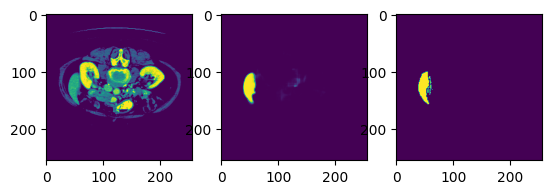

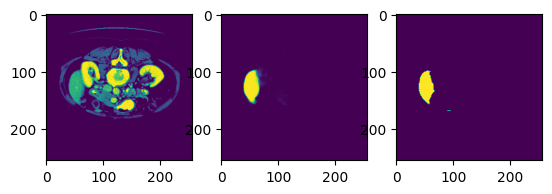

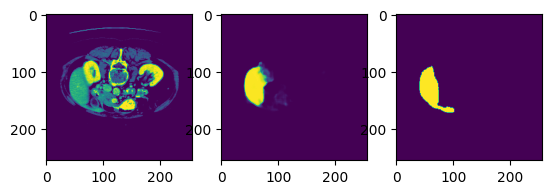

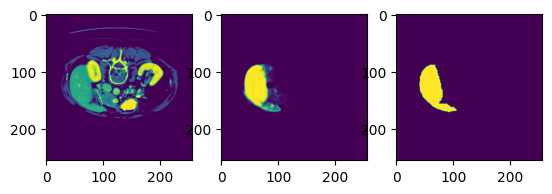

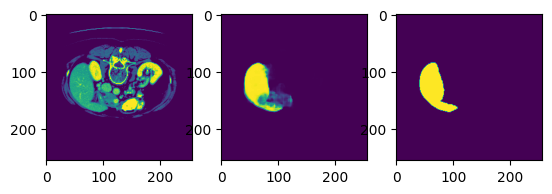

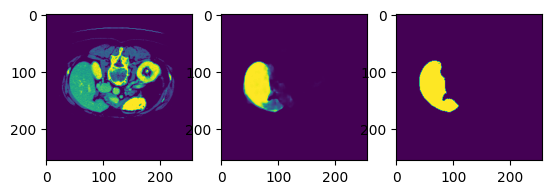

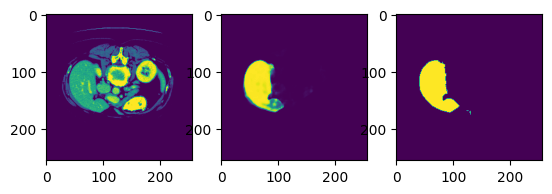

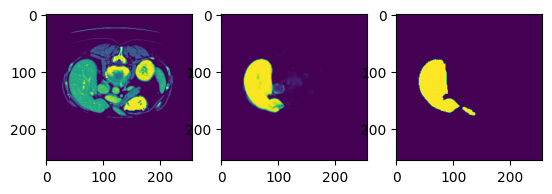

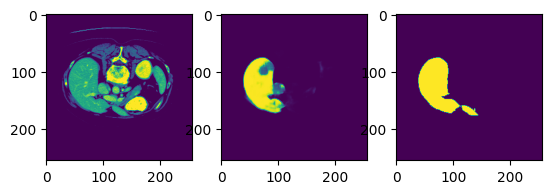

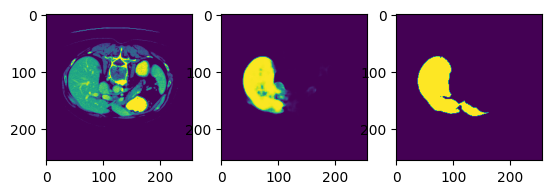

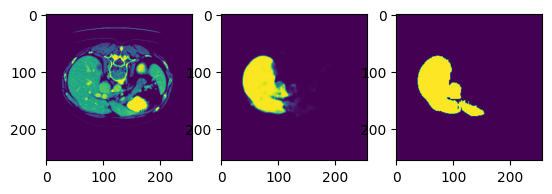

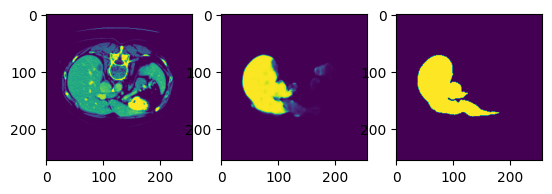

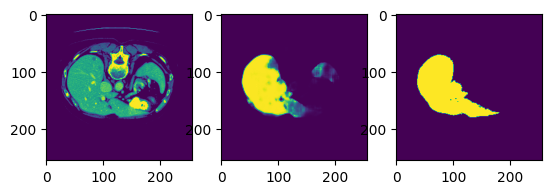

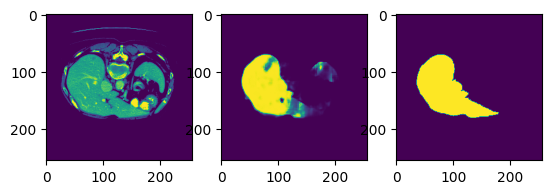

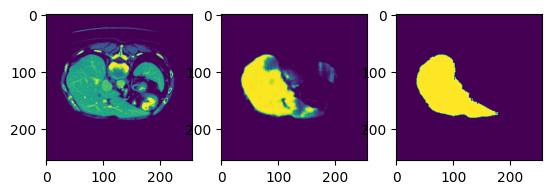

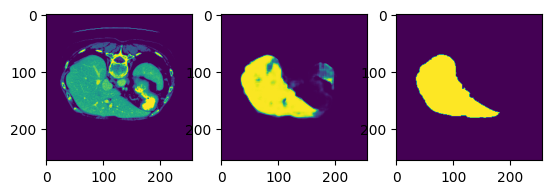

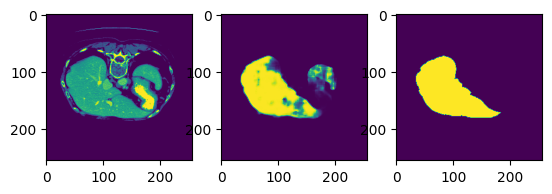

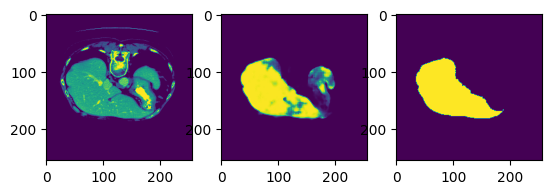

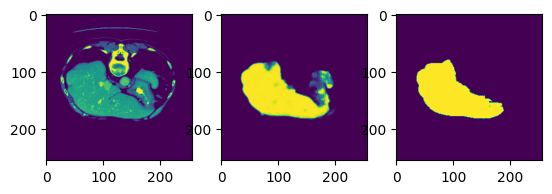

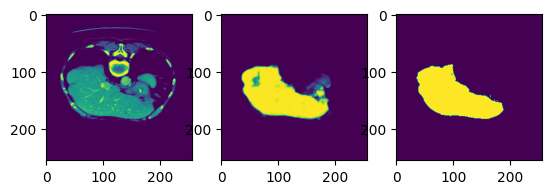

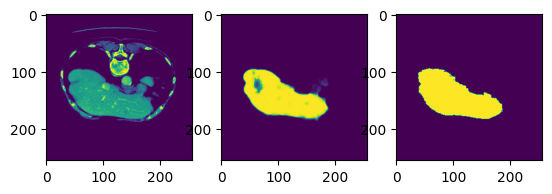

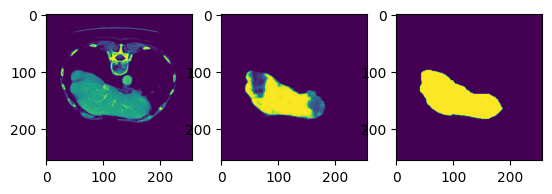

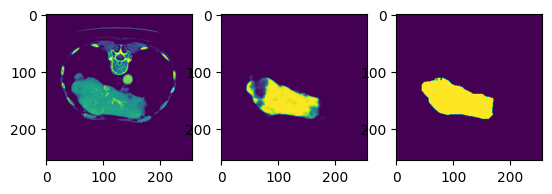

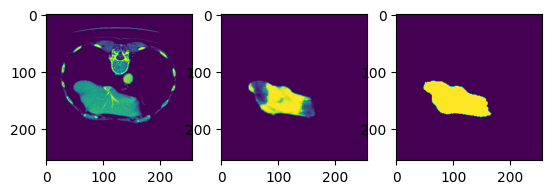

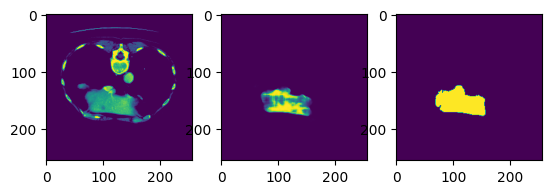

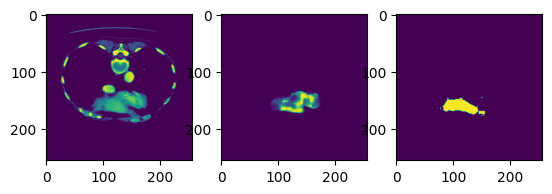

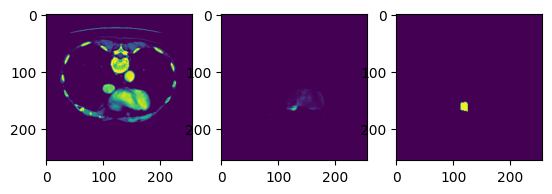

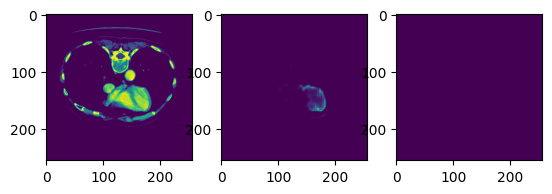

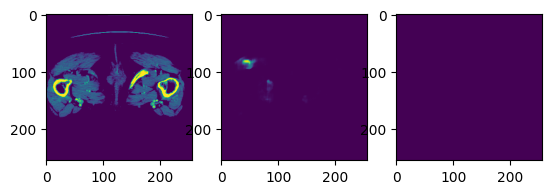

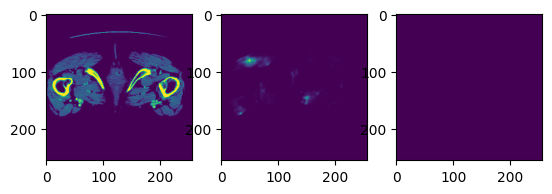

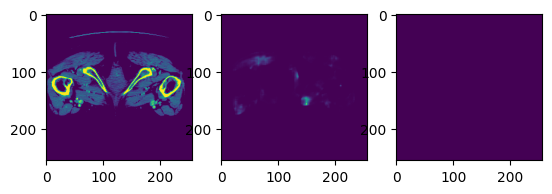

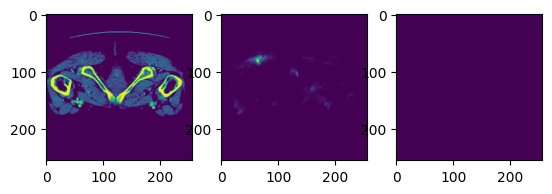

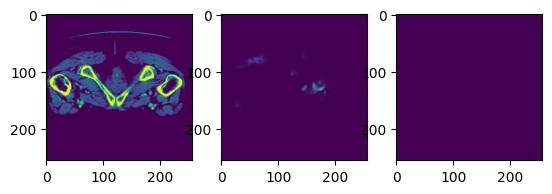

In [12]:
new_model = tf.keras.models.load_model("models\\2DUNET_liver_16_256\\50-0.0155-0.92-0.87.hdf5")



n_max = 80
n=0
for x in loader_valid.data_generator_2d_liver():
   if n < 40:
      pass
   elif n < n_max:
      plt.subplot(1,3,1)
      plt.imshow(x[0])
      plt.subplot(1,3,2)
      preds = new_model.predict(tf.reshape(x[0],[1,256,256,1]))
      plt.imshow(preds[0,:,:,1])
      plt.subplot(1,3,3)
      plt.imshow(x[1][:,:,1])
      plt.show()
   else:
      break
   n+=1